In [154]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [155]:
#Set computation device for PyTorch sensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [156]:
#Choose stock to predict
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [157]:
#Standardize the data using z-score normalization
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [158]:
#Set up LSTM model using 80/20 split
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [159]:
#Define LSTM model
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [160]:
#Train model

model = PredictionModel(input_dim=1, hidden_dim=64, num_layers=3, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.01)
    
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

In [161]:
# After training, evaluate the model
model.eval()
y_test_pred = model(X_test)
    
# Inverse transform predictions and true values
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())
    
# Calculate RMSE for test data
test_rmse = sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))

test_rmse


8.2016260721305

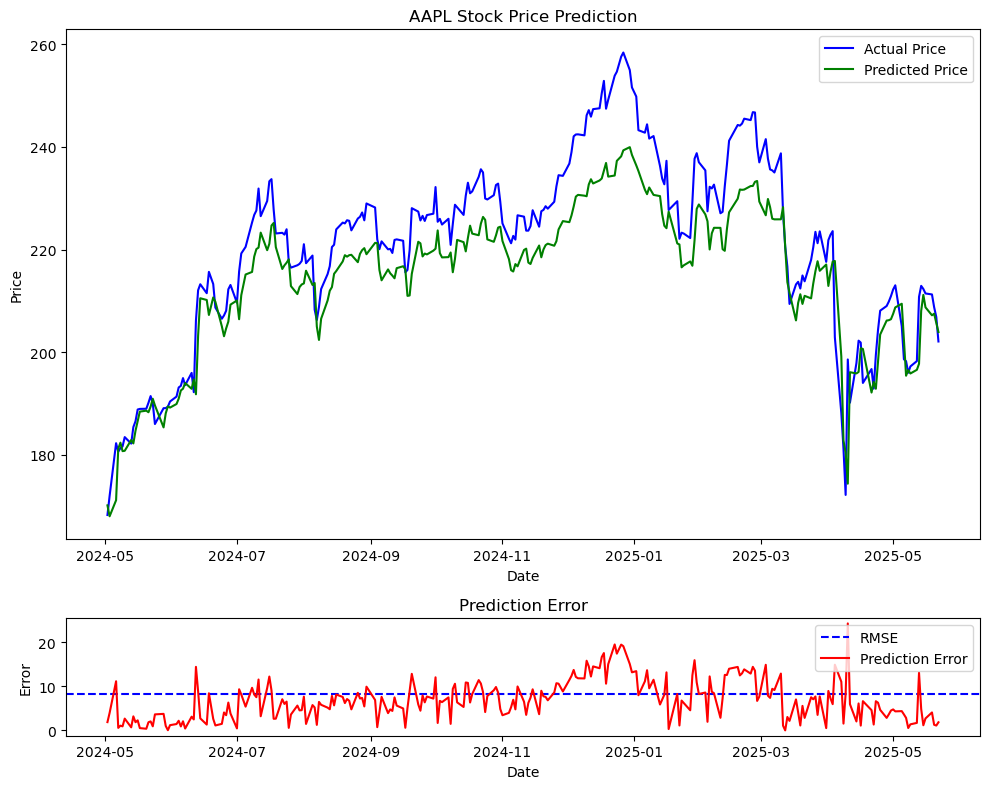

In [162]:
#Plot the predictions and the error
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test-y_test_pred), color = 'red', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [163]:
forecast_days = 30  # ~1 month of trading days
last_seq = data[-1]  # Last available sequence from the dataset
forecast = []

current_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    for _ in range(forecast_days):
        next_val = model(current_seq)
        forecast.append(next_val.item())

        # Update the sequence: drop first value, append prediction
        next_input = next_val.unsqueeze(1)
        current_seq = torch.cat((current_seq[:, 1:, :], next_input), dim=1)

# Inverse scale the forecast
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

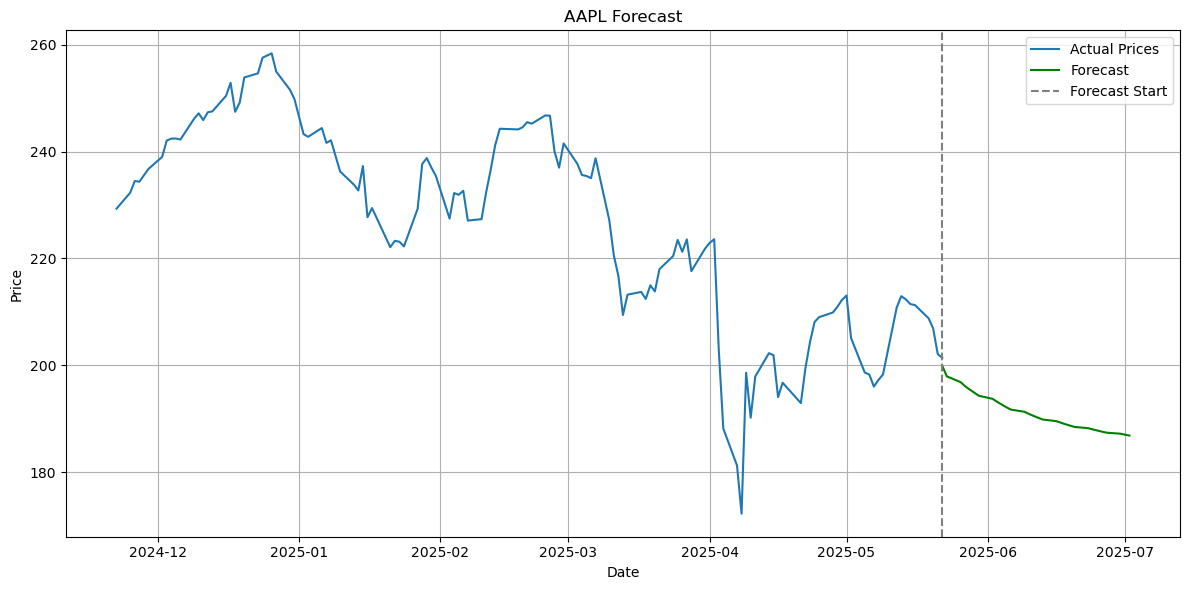

In [164]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date, periods=len(forecast))
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])
six_months_ago = df.index[-1] - pd.DateOffset(months=6)
recent_df = df[df.index >= six_months_ago]

plt.figure(figsize=(12, 6))
plt.plot(recent_df.index, scaler.inverse_transform(recent_df[['Close']]), label='Actual Prices')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green')
plt.axvline(x=last_date, linestyle='--', color='gray', label='Forecast Start')
plt.title(f'{ticker} Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()